# End-to-end Pipeline for YoloV4 Model Training

In this notebook, we will use a base implementation of the Yolov4 architecture which uses the PyTorch framework. We are using a forked version of this repo (https://github.com/Tianxiaomo/pytorch-YOLOv4) which has been modified for training with custom datasets. We have also made some minor adjustments to the forked repository to accomodate Amazon SageMaker Training.

Before we train our model, we need to create our training container image and ensure our dataset is in the appropriate format for PyTorch Yolov4 models.

## Create Docker training image

These steps are best executed on your local machine or somewhere that has Docker installed.

1. Navigate to this repository (https://github.com/kwwendt/sagemaker-yolov4-e2e-example) & follow the instructions to build, tag, and push the container to Amazon Elastic Container Registry.
2. Once complete, return back to the notebook for the remaining steps.

## Upload dataset to Amazon S3

For this step, we will upload our dataset to Amazon S3 so we can easily load the data into our container during model training.

In this demo, I am leveraging an open-source dataset provided by Roboflow: https://public.roboflow.com/object-detection/chess-full/24

It is free to create an account and they have an easy export option for PyTorch Yolov4 compatible datasets.

Once you have your dataset, we can upload our data to Amazon S3. It is best to separate your training, validation, and testing data into 3 folders in S3.

## Create the estimator

### Set up parameters & imports

In [18]:
import sys

!{sys.executable} -m pip install -q --upgrade sagemaker 

In [26]:
import boto3
import json
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.session import Session

sess = Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
role = get_execution_role()

In [ ]:
# Image URI for your docker training image
docker_img_uri = "<enter the output from the build_and_push_container.sh script>"
training_job_name = name_from_base('torch-yolov4-model')

# Location where the trained model resides in S3
model_path = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"

# Input shape and layer name
input_shape = [1,3,608,608]
input_layer_name = 'input0'
data_shape = json.dumps({input_layer_name: input_shape})

# Compiled model path for model compiled with Sagemaker Neo
compiled_model_path = f"s3://{bucket}/{training_job_name}/models/compiled"

# Number of classes in your dataset
n_classes = 13

### Create & train the estimator

In [ ]:
estimator = Estimator(
    image_uri=docker_img_uri,
    role=role,
    instance_type="ml.g4dn.2xlarge",
    volume_size=50,
    instance_count=1,
    max_run = 6 * 60 *60,
    hyperparameters={
        "pretrained": "yolov4.conv.137.pth",
        "classes": n_classes,
        "train_label": "_annotations.txt", # If your annotations file is named differently, please note the correct name here
        "val_label": "_annotations.txt", # If your annotations file is named differently, please note the correct name here
        "batch": 2,
        "subdivisions": 1,
        "learning_rate": 0.001,
        "gpu": "0",
        "epochs": 5
    }
)

In [ ]:
estimator.fit(job_name=training_job_name, inputs={
    "train": f"s3://{bucket}/yolov4_training_data/trainv2/", # The location in S3 where your training data and training annotations are stored
    "val": f"s3://{bucket}/yolov4_training_data/validv2/" # The location in S3 where your validation data and validation annotations are stored
})

## Clone Yolov4 repo

We also need to clone the Yolov4 repo we are using here so we can trace our trained model. Once you clone the repo, we need to move our notebook into the `pytorch-YOLOv4` directory so everything is on the same path.

In [ ]:
!git clone https://github.com/roboflow-ai/pytorch-YOLOv4.git

## Prepare trained model

In [ ]:
s3_client = boto3.client('s3')

with open('model.tar.gz', 'wb') as data:
    s3_client.download_fileobj(Bucket=bucket, Key=f'{training_job_name}/output/model.tar.gz', Fileobj=data)
weightfile = 'yolov4-trained-model.pth'

In [ ]:
!tar -zxvf model.tar.gz

In [ ]:
import torch
import models

model = models.Yolov4(n_classes=n_classes)
pretrained_dict = torch.load(weightfile, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_dict)
model.eval()

In [ ]:
input1 = torch.zeros(input_shape).float()

trace = torch.jit.trace(model.eval().float(), input1)
trace.save('model.pth')

In [ ]:
!tar -czvf traced-yolov4-model.tar.gz model.pth

In [ ]:
traced_model_path = sess.upload_data(path='traced-yolov4-model.tar.gz', key_prefix='models/traced')
print(traced_model_path)

## Create the compiled model with SageMaker Neo

In [ ]:
# Framework information
framework = 'PYTORCH'
framework_version = '1.6'
compilation_job_name = f"{training_job_name}-compilation"

sm_client = boto3.client('sagemaker', region_name=region)

In [ ]:
sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': traced_model_path,
        'DataInputConfig': data_shape,
        'Framework': framework,
        'FrameworkVersion': framework_version
    },
    OutputConfig={
        'S3OutputLocation': compiled_model_path,
        'TargetDevice': 'ml_g4dn'
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }    
)

import time
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(10)

Now we need to upload the `inference.py` entry point script so we can use it to create our model endpoint. Create a new folder called `code` and then upload the inference file into the new directory.

In [ ]:
!mkdir code

In [60]:
!cp tool/utils.py code/

In [20]:
env_vars = {"COMPILEDMODEL": 'False', 'MMS_MAX_RESPONSE_SIZE': '100000000', 'MMS_DEFAULT_RESPONSE_TIMEOUT': '120'}

In [78]:
from sagemaker.pytorch import PyTorchModel

# Create SageMaker model and deploy an endpoint
# This is for the non-optimized model.
sm_pytorch_compiled_model = PyTorchModel(
    model_data=f"s3://{bucket}/models/traced/traced-yolov4-model.tar.gz",#f"{compiled_model_path}/traced-yolov4-model-ml_g4dn.tar.gz",
    role=role,
    entry_point='inference.py',
    source_dir='code',
    framework_version=framework_version,
    py_version='py3',
    env=env_vars
)

In [79]:
# Replace the example instance_type below to your preferred instance_type
predictor = sm_pytorch_compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.g4dn.xlarge')

# Print the name of newly created endpoint
print(predictor.endpoint_name) 

INFO:sagemaker:Creating model with name: pytorch-inference-2021-07-13-23-05-48-351
INFO:sagemaker:Creating endpoint with name pytorch-inference-2021-07-13-23-05-48-660


-------!pytorch-inference-2021-07-13-23-05-48-660


Now that our endpoint is deployed, you can test with a sample image from your test set.

In [105]:
import boto3

client = boto3.client('sagemaker-runtime', region_name='us-west-2')

content_type = 'application/x-image'

img_name = "IMG_0293_JPG.rf.e208f5cdf5e993c552be7f96e86c4890.jpg" # Add your image here

with open(img_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

response = client.invoke_endpoint(EndpointName=predictor.endpoint_name, Body=payload, ContentType=content_type)
stream_body = response['Body']

In [106]:
from sagemaker.deserializers import NumpyDeserializer

deser = NumpyDeserializer()
temp_boxes = deser.deserialize(stream_body, 'application/x-npy')

In [ ]:
def plot_boxes(img, boxes, savename=None, class_names=None):
    colors = torch.FloatTensor([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]]);

    def get_color(c, x, max_val):
        ratio = float(x) / max_val * 5
        i = int(math.floor(ratio))
        j = int(math.ceil(ratio))
        ratio = ratio - i
        r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
        return int(r * 255)

    width = img.width
    height = img.height
    draw = ImageDraw.Draw(img)
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = (box[0] - box[2] / 2.0) * width
        y1 = (box[1] - box[3] / 2.0) * height
        x2 = (box[0] + box[2] / 2.0) * width
        y2 = (box[1] + box[3] / 2.0) * height
        
        rgb = (255, 0, 0)
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = int(box[6])
            
            print('%s: %f' % (class_names[cls_id], cls_conf))
            classes = len(class_names)
            offset = cls_id * 123457 % classes
            red = get_color(2, offset, classes)
            green = get_color(1, offset, classes)
            blue = get_color(0, offset, classes)
            rgb = (red, green, blue)
            draw.text((x1, y1), class_names[cls_id], fill=rgb)
        draw.rectangle([x1, y1, x2, y2], outline=rgb)
    if savename:
        print("save plot results to %s" % savename)
        img.save(savename)
    return img

white-knight: 0.592866
black-pawn: 0.991016
white-knight: 0.311385
white-pawn: 0.498718
black-pawn: 0.976016
black-knight: 0.338371
white-pawn: 0.910365
black-knight: 0.340039
save plot results to predictions.jpg


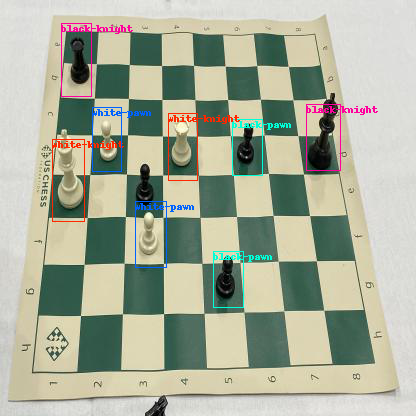

In [107]:
from tool import utils
from PIL import Image

class_names = utils.load_class_names('dataset.names')

img = Image.open(img_name).convert('RGB')
plot_boxes(img, temp_boxes, 'predictions.jpg', class_names)